In [8]:
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import cv2
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, precision_score, recall_score, matthews_corrcoef
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss
from torch.utils import data
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
OR_PATH = os.getcwd()
PATH = OR_PATH
sep = os.path.sep

FILENAME = PATH + sep + "Deborah" + sep +"Final-Project-Group4" + sep + "dataset"  + "final_dataset.xlsx"
DATA_DIR = PATH + sep + "Deborah" + sep +"Final-Project-Group4"+ sep +  "train" + os.path.sep


#Inception net must have image sizes as 299 * 299
n_epoch = 2
BATCH_SIZE = 32
LR = 0.0005

## Image processing
CHANNELS = 3
IMAGE_SIZE = 299

NICKNAME = "Group4"

mlb = MultiLabelBinarizer()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
THRESHOLD = 0.5
SAVE_MODEL = True


In [10]:
xdf_data = pd.read_excel(FILENAME)

xdf_dtrain = xdf_data[xdf_data['Split'] == 'train'].copy()
xdf_dtest = xdf_data[xdf_data['Split'] == 'test'].copy()


""" Custom data class to read in the images one sample at a time using the image ImageId

    Processing the multilabel target(catgeory) into one-hot-encoding
    
    Returns the transformed images and labels

"""

class ImageDataset(data.Dataset):
    def __init__(self, list_IDs, type_data, target_type):
        #Initialization'
        self.type_data = type_data
        self.list_IDs = list_IDs
        self.target_type = target_type
        
        self.transforms = v2.Compose([
            transforms.Resize((299, 299)),
            v2.CenterCrop(299),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
            v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
    #Denotes the total number of samples'  
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        
        #Genrate one sample at a time by using loading the image file and the id
        ID = self.list_IDs[index]

        # Load data and get label

        if self.type_data == 'train':
            y = xdf_dtrain.target_class.get(ID)
            if self.target_type == 2:
                y = y.split(",")
        else:
            y = xdf_dtest.target_class.get(ID)
            if self.target_type == 2:
                y = y.split(",")


        if self.target_type == 2:
            labels_ohe = [ int(e) for e in y]
        else:
            labels_ohe = np.zeros(OUTPUTS_a)

            for idx, label in enumerate(range(OUTPUTS_a)):
                if label == y:
                    labels_ohe[idx] = 1

        y = torch.FloatTensor(labels_ohe)

        if self.type_data == 'train':
            file = DATA_DIR + xdf_dtrain.ImageId.get(ID)
        else:
            file = DATA_DIR + xdf_dtest.ImageId.get(ID)

        img = cv2.imread(file)

        img= cv2.resize(img,(IMAGE_SIZE, IMAGE_SIZE))

        # Augmentation for training
        X = torch.FloatTensor(img)

        X = torch.reshape(X, (3, IMAGE_SIZE, IMAGE_SIZE))

        if self.type_data == 'train':
            X = self.transforms(X)


        return X, y





def process_target(target_type):
    '''
        1- Binary   target = (1,0)
        2- Multiclass  target = (1...n, text1...textn)
        3- Multilabel target = ( list(Text1, Text2, Text3 ) for each observation, separated by commas )
    :return:
    '''

    dict_target = {}
    xerror = 0

    if target_type == 2:
        ## The target comes as a string  x1, x2, x3,x4
        ## the following code creates a list
        target = np.array(xdf_data['Category'].apply( lambda x : x.split(",")))
        final_target = mlb.fit_transform(target)
        xfinal = []
        if len(final_target) ==0:
            xerror = 'Could not process Multilabel'
        else:
            class_names = mlb.classes_
            for i in range(len(final_target)):
                joined_string = ",".join( str(e) for e in final_target[i])
                xfinal.append(joined_string)
            xdf_data['target_class'] = xfinal

    if target_type == 1:
        xtarget = list(np.array(xdf_data['Category'].unique()))
        le = LabelEncoder()
        le.fit(xtarget)
        final_target = le.transform(np.array(xdf_data['Category']))
        class_names=(xtarget)
        xdf_data['target_class'] = final_target
        
        
    ## Calculate class weights based on the frequency of each class in the dataset, finally worked!!!
    label_matrix = xdf_dtrain['Category'].str.get_dummies(",")
    class_dist = label_matrix.sum()
    total_num_samples = class_dist.sum()
    class_weights = total_num_samples / (class_dist * len(class_dist))
    class_weight_tensor = torch.tensor(class_weights.values, dtype=torch.float)
    sample_weights = label_matrix.dot(class_weight_tensor).values

    return class_names, sample_weights
    

class_names, sample_weights = process_target(2)
OUTPUTS_a = len(class_names)


xdf_dtrain = xdf_data[xdf_data['Split'] == 'train'].copy()
xdf_dtest = xdf_data[xdf_data['Split'] == 'test'].copy()

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/DeborahFinal-Project-Group4/datasetfinal_dataset.xlsx'

In [4]:
#Create custom model
class FashionNet(nn.Module):
    def __init__(self):
        super(FashionNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3))
        self.convnorm1 = nn.BatchNorm2d(16)
        self.pad1 = nn.ZeroPad2d(2)

        self.conv2 = nn.Conv2d(16, 128, (3, 3))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.conv3 = nn.Conv2d(128, 100, (3, 3))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(100, OUTPUTS_a)
        self.act = torch.relu

    def forward(self, x):
        x = self.pad1(self.convnorm1(self.act(self.conv1(x))))
        x = self.act(self.conv2(self.act(x)))
        return self.linear(self.global_avg_pool(x).view(-1, 128))

In [5]:
def read_data(target_type):
    ## Only the training set
    ## read the data data from the file
    
    class_names, sample_weights = process_target(2)

    ds_inputs = np.array(DATA_DIR + xdf_dtrain['ImageId'])

    ds_targets = xdf_dtrain['target_class']

    # ---------------------- Parameters for the data loader --------------------------------

    list_of_ids = list(xdf_dtrain.index)
    list_of_ids_test = list(xdf_dtest.index)

    # Datasets
    partition = {'train': list_of_ids,'test' : list_of_ids_test}
 

    # Create WeightedRandomSampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(list_of_ids), replacement=True)
    
    # Data Loaders, shuffle is mutually exclusive with sampler error, cannot pass in shuffle=True
    train_params = {'batch_size': BATCH_SIZE, 'num_workers':4, 'sampler':sampler}
    params = {'batch_size': BATCH_SIZE, 'num_workers':2}
    
    training_set = ImageDataset(partition['train'], 'train', target_type)
    training_generator = data.DataLoader(training_set, **train_params)

    test_set = ImageDataset(partition['test'], 'test', target_type)
    test_generator = data.DataLoader(test_set, **params)

    ## Make the channel as a list to make it variable
    return training_generator, test_generator


def save_model(model):
    # Open the file

    print(model, file=open('summary_inception{}.txt'.format(NICKNAME), "w"))
    
read_data(2)

(<torch.utils.data.dataloader.DataLoader at 0x7416f522b340>,
 <torch.utils.data.dataloader.DataLoader at 0x7416f5228c70>)

In [6]:
""" 
alpha: Scale the focal weight with alpha.

gamma: Take the power of the focal weight with gamma.

Returns focal weight * Binary binary_cross_entropy

#The closer to zero gamma is, the more confident in the class predicted. 
"""


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        prob_t = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-prob_t)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss
        
        

def model_definition(pretrained=False):
    # Define a Keras sequential model
    # Compile the model

    if pretrained == True:
        model = models.inception_v3()
        model.fc = nn.Linear(model.fc.in_features, OUTPUTS_a)
        model.fc.requires_grad = True
    else:
        model = FashionNet()

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion= FocalLoss()
    #criterion = nn.BCEWithLogitsLoss()

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)

    save_model(model)

    return model, optimizer, criterion, scheduler

In [7]:
def metrics_func(metrics, aggregates, y_true, y_pred):
    '''
    multiple functiosn of metrics to call each function f1, cohen, accuracy, mattews correlation
    list of metrics: f1_micro, f1_macro, f1_avg, coh, acc, mat list of aggregates : avg, sum
    :returns:
    '''

    def f1_score_metric(y_true, y_pred, type):
        '''
        type = micro,macro,weighted,samples
        :param y_true:
        :param y_pred:
        :param average:
        :return: res
        '''
        res = f1_score(y_true, y_pred, average=type)
        return res

    def cohen_kappa_metric(y_true, y_pred):
        res = cohen_kappa_score(y_true, y_pred)
        return res

    def accuracy_metric(y_true, y_pred):
        res = accuracy_score(y_true, y_pred)
        return res
    
    def precision_metric(y_true, y_pred, type):
        res = precision_score(y_true, y_pred, average=type)
        return res

    def recall_metric(y_true, y_pred, type):
        res = recall_score(y_true, y_pred, average=type)
        return res

    xcont = 1
    xsum = 0
    xavg = 0
    res_dict = {}
    
    for xm in metrics:
        if xm == 'f1_micro':
            # f1 score average = micro
            xmet = f1_score_metric(y_true, y_pred, 'micro')
        elif xm == 'f1_macro':
            # f1 score average = macro
            xmet = f1_score_metric(y_true, y_pred, 'macro')
        elif xm == 'f1_weighted':
            # f1 score average =
            xmet = f1_score_metric(y_true, y_pred, 'weighted')
        elif xm == 'coh':
             # Cohen kappa
            xmet = cohen_kappa_metric(y_true, y_pred)
        elif xm =='precision':
            xm == precision_metric(y_true, y_pred, 'average')
        elif xm == 'acc':
            # Accuracy
            xmet = accuracy_metric(y_true, y_pred)
        else:
            xmet = 0

        res_dict[xm] = xmet

        xsum = xsum + xmet
        xcont = xcont +1

    if 'sum' in aggregates:
        res_dict['sum'] = xsum
    if 'avg' in aggregates and xcont > 0:
        res_dict['avg'] = xsum/xcont
    # Ask for arguments for each metric

    return res_dict

/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 285/285 [03:55<00:00,  1.21it/s, Test Loss: 1.74762]


Epoch 0:  Train f1_macro 0.00483 Train avg 0.00242 -  Test f1_macro 0.05271 Test avg 0.02636
Precision : 0.4912860328735442, Recall : 0.36356227460728185


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 285/285 [03:54<00:00,  1.21it/s, Test Loss: 4.80321]


Epoch 1:  Train f1_macro 0.00072 Train avg 0.00036 -  Test f1_macro 0.03399 Test avg 0.01699
Precision : 0.4463760595052759, Recall : 0.10515270675006622


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 285/285 [03:57<00:00,  1.20it/s, Test Loss: 6.09385]


Epoch 2:  Train f1_macro 0.00035 Train avg 0.00017 -  Test f1_macro 0.06182 Test avg 0.03091
Precision : 0.5651134020618557, Recall : 0.4188178724964854


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 285/285 [03:55<00:00,  1.21it/s, Test Loss: 0.29056]


Epoch 3:  Train f1_macro 0.00062 Train avg 0.00031 -  Test f1_macro 0.05569 Test avg 0.02785
Precision : 0.5156354930070951, Recall : 0.35981336973574296


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 285/285 [03:54<00:00,  1.21it/s, Test Loss: 20.41899]


Epoch 4:  Train f1_macro 0.00005 Train avg 0.00002 -  Test f1_macro 0.07531 Test avg 0.03765
Precision : 0.31246734677042376, Recall : 0.46305087508404474


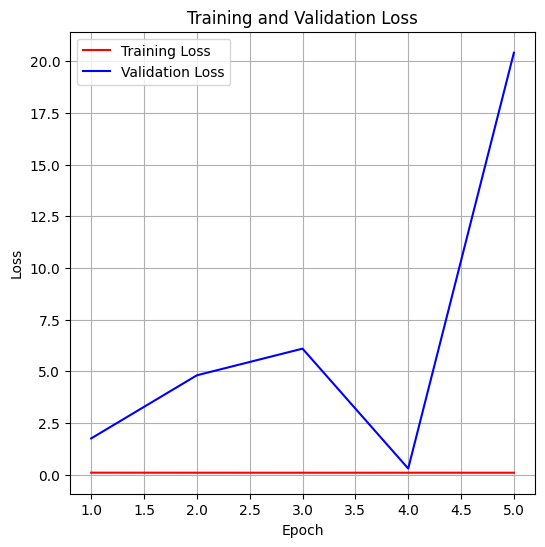

In [8]:


def train_and_test(train_ds, test_ds, list_of_metrics, list_of_agg, save_on, pretrained=False):
    
    # list_of_metrics, list_of_agg, save_on='f1_macro',
    
    # Define the model, optimizer, criterion, scheduler, and other necessary components
    model, optimizer, criterion, scheduler = model_definition(pretrained=pretrained)
    
    # logits = inception_outputs.logits, add this for inceptionnet to work and loss = F.binary_cross_entropy_with_logits(logits, target)

    count = 0
    
    #Save the training and testing loss
    train_loss_item = []
    test_loss_item = []

    #Track the best test metric
    met_test_best = 0

    for epoch in range(n_epoch):
        
        train_loss, steps_train = 0, 0
        # Set the model to training mode
        model.train()
        
        train_hist = list([])
        test_hist = list([])

        # Iterate through the training dataset
        with tqdm(total=len(train_ds), desc="Epoch {}".format(epoch)) as pbar:
            
            pred_logits = []
            real_labels = []
            
            #forward pass
            for xdata, xtarget in train_ds:
                xdata, xtarget = xdata.to(device), xtarget.to(device)      
                optimizer.zero_grad()
                output = model(xdata)
                
                #error
                loss = criterion(output.logits, xtarget)
                
                #backward pass
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
                count +=1
                steps_train += 1
                
                # Detach the tensor and move it to CPU before converting to numpy
                pred_labels= output.logits.cpu().detach().numpy()

                if len(train_hist) == 0:
                    train_hist = xtarget.cpu().numpy()
                else:
                    train_hist = np.vstack([train_hist, xtarget.cpu().numpy()])

                # Update progress bar
                pbar.update(1)
                pbar.set_postfix_str("Train Loss: {:.5f}".format(train_loss / steps_train))
                
                 # Extend pred_logits and real_labels
                pred_logits.extend(pred_labels)
                real_labels.extend(xtarget.cpu().numpy())
            
            
        pred_labels = np.array(pred_logits)
        pred_labels[pred_labels >= THRESHOLD] = 1
        pred_labels[pred_labels < THRESHOLD] = 0
        
        real_labels = np.array(real_labels)

        #Metric Evaluation
        train_metrics = metrics_func(list_of_metrics, list_of_agg, real_labels, pred_labels)
        acc_train = accuracy_score(real_labels, pred_labels)
        avg_train_loss = train_loss / steps_train
        train_loss_item.append(avg_train_loss)
          
        
        
        # Evaluation mode
        model.eval()
            
        pred_logits_test = []
        real_labels_test = []
        #Iterate through the testing dataset
        test_loss, steps_test = 0, 0
        met_test = 0
            
        with torch.no_grad():
            
            with tqdm(total=len(test_ds), desc="Epoch {}".format(epoch)) as pbar:
                
                for xdata, xtarget in test_ds:
                    
                    xdata, xtarget = xdata.to(device), xtarget.to(device)
                    optimizer.zero_grad()
                    output = model(xdata)
                    loss = criterion(output, xtarget)
                    test_loss += loss.item()
                    count +=1
                    steps_test += 1
                

                    # Detach the tensor and move it to CPU before converting to numpy
                    pred_labels_test = output.cpu().detach().numpy()
                        
                    if len(test_hist) == 0:
                        test_hist = xtarget.cpu().numpy()
                    else: 
                        test_hist = np.vstack([test_hist, xtarget.cpu().numpy()])

                    #Update progress bar
                    pbar.update(1)
                    pbar.set_postfix_str("Test Loss: {:.5f}".format(test_loss / steps_test))
                    
                     # Extend pred_logits and real_labels
                    pred_logits_test.extend(pred_labels_test)
                    real_labels_test.extend(xtarget.cpu().numpy())
                
        pred_labels = np.array(pred_logits_test)
        pred_labels[pred_labels >= THRESHOLD] = 1
        pred_labels[pred_labels < THRESHOLD] = 0
        real_labels = np.array(real_labels_test)
                    
        
        # Metric Evaluation
        test_metrics = metrics_func(list_of_metrics, list_of_agg, real_labels, pred_labels)
        prec = precision_score(real_labels, pred_labels, average="micro")
        recall = recall_score(real_labels, pred_labels, average="micro")
        avg_test_loss = test_loss / steps_test
        test_loss_item.append(avg_test_loss)

        xstrres = "Epoch {}: ".format(epoch)
        for met, dat in train_metrics.items():
            xstrres = xstrres +' Train '+met+ ' {:.5f}'.format(dat)


        xstrres = xstrres + " - "
        for met, dat in test_metrics.items():
            xstrres = xstrres + ' Test '+met+ ' {:.5f}'.format(dat)
            if met == save_on:
                met_test = dat

        print(xstrres)

        if met_test > met_test_best and SAVE_MODEL:

            torch.save(model.state_dict(), "model_inception{}.pt".format(NICKNAME))
            met_test_best = met_test
            
        print(f"Precision : {prec}, Recall : {recall}")

    epochs = range(1, n_epoch + 1)
    # Plotting
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, train_loss_item, label='Training Loss', c='red')
    plt.plot(epochs, test_loss_item, label='Validation Loss',c='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("inceptionent_training_and_validation errors.png")
    
    
    plt.show()    
    

list_of_metrics = ['f1_macro']
list_of_agg = ['avg']
                  
train_ds, test_ds = read_data(2)  
train_and_test(train_ds, test_ds, list_of_metrics, list_of_agg, save_on="f1_macro", pretrained=True)



In [ ]:
#Validation error increases sharply after epoch 4. Class weights and focal loss function were used to
# penalize well predicted classes to favor least accurately predicted classes